In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

In [25]:
data = pd.read_csv("/content/Reviews.csv", engine='python',error_bad_lines=False)
data.head()

Skipping line 513661: unexpected end of data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [26]:
data.shape[0]

513659

In [27]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [28]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,14
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,26
Text,0


In [29]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 40

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [30]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 153091

Percentage of data removed: 29.8%
Percentage of data remaining: 70.19%


In [31]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:70.19%


In [32]:
## `Score` > 3 : "Positive" 
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):
    
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [33]:
# target column 
data[['Score', 'target']].sample(5)

,Score,target
133213,3,Neutral
5258,5,Positive
69414,5,Positive
102147,5,Positive
333694,5,Positive


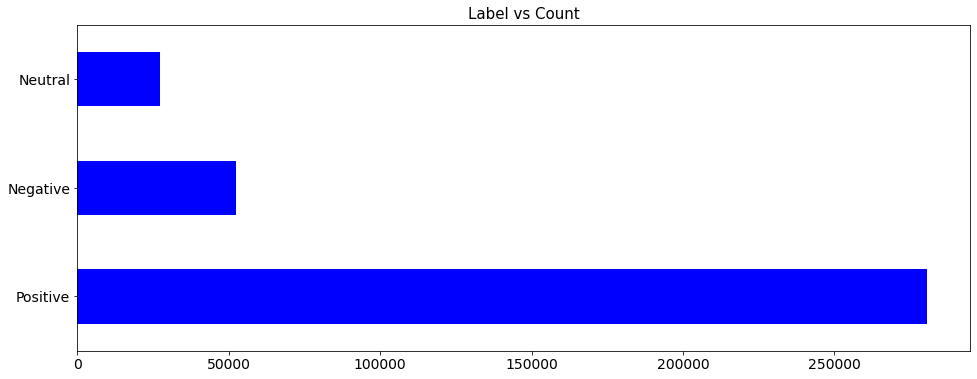

In [34]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [35]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(127289, 11)

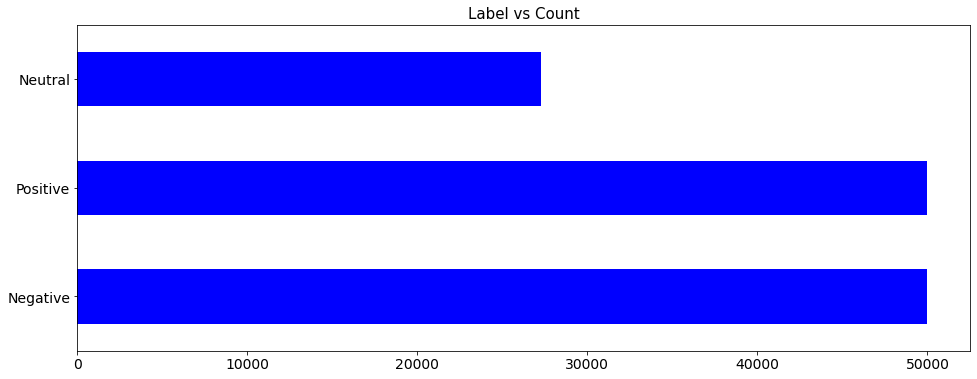

In [36]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [39]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'am', 'as', 'only', 'wouldn', 'we', 'don', 'one', 'in', 'weren', "should've", 'or', 'can', 'and', 'of', 'll', 've', "that'll", 'doesn', 'below', 'ours', 'which', 'but', 'how', 'himself', 'did', 'is', 'my', 'mustn', 'mightn', 'won', 'further', 'after', "you've", 'her', 'have', 'shouldn', 'why', 'you', 'does', 'has', 'd', 'on', 'them', 'y', 'their', 'other', "she's", 'i', 'your', 'through', 'a', 'because', 'him', 'aren', 'each', 'so', 'with', 'what', 'o', 'this', 'own', 'wasn', 'didn', 'the', 'that', 'too', 'just', 'hasn', 'she', 'at', 'being', 'during', 't', 'most', 'very', "you'll", 'for', 'to', 'again', 'ourselves', 'hers', 'out', 'who', 'its', 'm', 'these', 'once', 'had', 'into', 'some', 'if', 'up', "you'd", 'over', 'before', 'when', 'yourself', 'were', 'while', 'whom', 'doing', 'against', 'an', 'herself', 'our', 'those', 'are', 'under', 'should', 're', 'been', 'he', 'until', 'by', 'few', 'where', 'needn', 's', 'themselves', 'ain', 'more', 'they', "you're", 'his', 'me', 'having', 'i

In [38]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [41]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

In [42]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'<a href="http://www.amazon.com/gp/product/B001E5E056">Kashi Heart to Heart Blueberry Flake and Cluster Oat Cereal, 13.4-Ounce Boxes (Pack of 6)</a> I love eating a cereal that tastes so good and have the added benefit of tasting good as well.'

In [43]:
data.Text = data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'kashi heart heart blueberri flake cluster oat cereal ounc box pack love eat cereal tast good ad benefit tast good well'

In [44]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

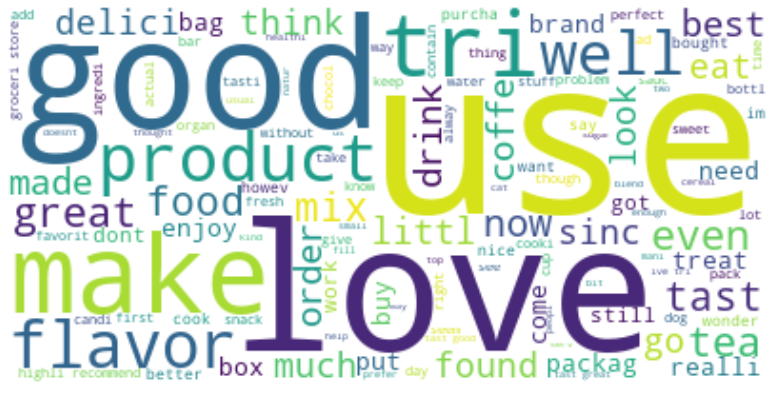

In [45]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

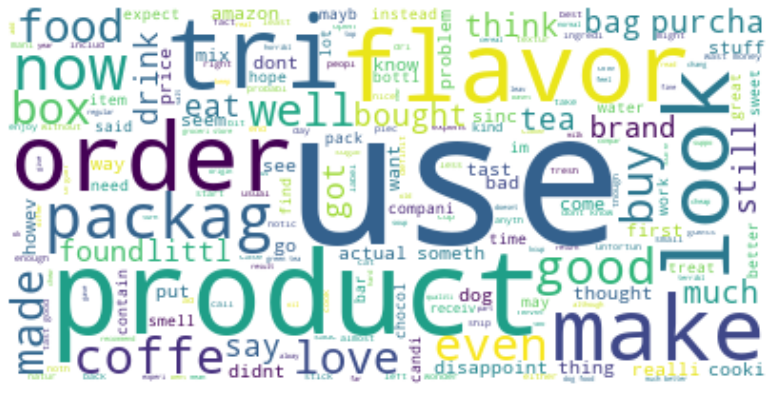

In [46]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

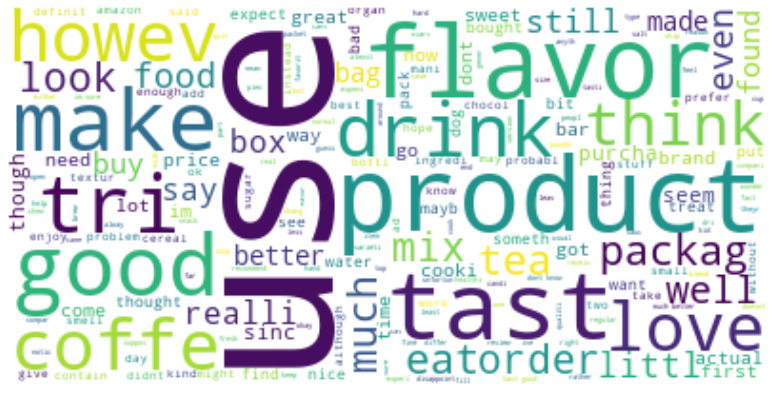

In [47]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

In [51]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [52]:
X_train.shape, X_test.shape

((101831,), (25458,))

In [53]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

In [54]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [55]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


In [57]:
### 
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

In [58]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.657776119256415
Test accuracy score : 0.6557860004713646

 ----------------------------------------

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.6847030864864334
Test accuracy score : 0.6805326419985859

 ----------------------------------------

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   i

In [59]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

In [60]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [62]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.7692058410503677
Test accuracy score : 0.7282583078010841


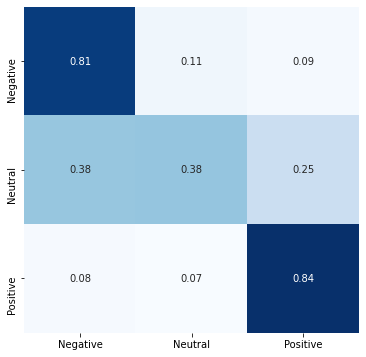

In [63]:
plot_cm(y_test, y_preds_test)

In [64]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

In [65]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [69]:
# positve review
review = "The food has great taste"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!
